In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

In [2]:
# Import the data frames
wf = pd.read_csv('data/datasets/fake_domain_word_freq.csv')
df = pd.read_csv('data/datasets/fake_real_domains_combined.csv')
rs = pd.read_csv('data/datasets/reg_scores.csv')

In [3]:
# Score domain keywords based on word frequencies in the sample
for e, dom in enumerate(df['dom_split']):
    dom_split = dom.split(' ')
    score = 0
    for word in dom_split:
        try:
            prob = wf.loc[wf['word'] == word, 'samp_freq'].values[0]
        except IndexError: prob = 0
        score += prob
    df.loc[e, 'dom_score'] = score
mult = 1/df['dom_score'].max()
df['dom_score'] = df['dom_score'] * mult

In [4]:
# Score registrars based on word frequencies in the sample
for e, reg in enumerate(df['registrar']):
    score = 0
    other_val = rs.loc[rs['registrar'] == 'Other', 'reg_score'].values[0]
    try:
        prob = rs.loc[rs['registrar'] == reg, 'reg_score'].values[0]
    except IndexError: prob = other_val
    df.loc[e, 'reg_score'] = score

df.tail()

,rank,domain,tld,registrar,updated_date,creation_date,expiration_date,trust,dom_split,domain_length,keyword_length,num_nameservers,dom_age_days,dom_last_update,days_to_exp,update_to_exp,dom_score,reg_score
25296,NaN,altervista,org,tucows,2020-08-29T20:04:42Z,2000-12-22T18:05:39Z,2025-12-22T18:05:39Z,initial trust,altervista,10,1,4,7251.736708,61.654034,1879.263292,1817.609257,0.000000,0.0
25297,NaN,at,ua,тов інтернет інвест,2020-07-17T13:34:02Z,2007-08-01T15:33:00Z,2021-08-01T15:32:58Z,initial trust,at,2,1,2,4838.842715,104.925331,275.157262,170.231931,0.000000,0.0
25298,NaN,readthedocs,io,namecheap,2020-05-15T07:14:10Z,2014-06-14T19:58:22Z,2021-06-14T19:58:22Z,initial trust,read the docs,11,3,4,2329.658433,168.189127,227.341567,59.152440,0.000000,0.0
25299,NaN,web,app,markmonitor,2019-12-12T10:38:09Z,2019-01-08T22:05:04Z,2021-01-08T22:05:04Z,initial trust,web,3,1,4,660.570446,323.047472,70.429553,-252.617919,0.004525,0.0
25300,NaN,plesk,page,namecheap,2020-06-08T11:00:08Z,2020-03-18T03:06:27Z,2021-03-18T03:06:27Z,initial trust,plesk,5,1,3,226.361152,144.032206,138.638847,-5.393358,0.000000,0.0


In [5]:
# Fill NAs for rank with the highest known one
df['rank'] = df['rank'].fillna(df['rank'].max())

In [6]:
features = ['domain_length', 'keyword_length', 'num_nameservers',
            'dom_age_days', 'dom_score', 'reg_score', 'rank']

len(df[features].dropna()) % 3

2

In [7]:
# Ensure even splits for the train/test/validate sets
print('Starting length: {}'.format(len(df)))
remove_n = len(df) % 3
drop_indices = np.random.choice(df.index, remove_n, replace=False)
df = df.drop(drop_indices)
print('Ending length: {}'.format(len(df)))

Starting length: 25301
Ending length: 25299


In [8]:
# Create the split datasets for train, validate, and test
train, validate, test = np.split(
    df.sample(frac=1, random_state=42), [int(.6*len(df)), int(.8*len(df))])

y = train['trust']

In [9]:
# Check for NaN values in the sets
print(train[features].isnull().sum().sum())
print(validate[features].isnull().sum().sum())
print(test[features].isnull().sum().sum())

0
0
0


In [10]:
df[features].tail()

,domain_length,keyword_length,num_nameservers,dom_age_days,dom_score,reg_score,rank
25296,10,1,4,7251.736708,0.000000,0.0,765288.0
25297,2,1,2,4838.842715,0.000000,0.0,765288.0
25298,11,3,4,2329.658433,0.000000,0.0,765288.0
25299,3,1,4,660.570446,0.004525,0.0,765288.0
25300,5,1,3,226.361152,0.000000,0.0,765288.0


In [11]:
# Train the classifier
X = pd.get_dummies(train[features])
X_test = pd.get_dummies(test[features])

model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=1)
model.fit(X, y)
predictions = model.predict(X_test)

In [12]:
# Create confusion matrix
pd.crosstab(test['trust'], predictions, rownames=['Actual trust'], colnames=['Predicted trust'])

Predicted trust,fake,initial trust
Actual trust,,
fake,508,20
initial trust,2,4530


In [13]:
# View a list of the features and their importance scores
list(zip(train[features], model.feature_importances_))

[('domain_length', 0.049907939988694035),
 ('keyword_length', 0.00807947852016772),
 ('num_nameservers', 0.010993911278435374),
 ('dom_age_days', 0.0734469944276016),
 ('dom_score', 0.21613020134771627),
 ('reg_score', 0.0),
 ('rank', 0.6414414744373851)]

In [14]:
# Review the output
output = pd.DataFrame({'domain': test.domain,
                       'assigned_trust': test.trust,
                       'prediction': predictions,
                       'correct': test.trust == predictions})

print(output.loc[output['correct'] == False])
num_false = len(output.loc[output['correct'] == False])
samp_size = len(output)
print('Number of samples: {}'.format(samp_size))
print('Number of errors: {}'.format(num_false))
print('Total correct: {}%'.format(1 - (num_false/samp_size)))

                         domain assigned_trust     prediction  correct
21932                 pewtrusts           fake  initial trust    False
3915             nationalreview           fake  initial trust    False
19391           dollarvigilante           fake  initial trust    False
21485            whatdoesitmean           fake  initial trust    False
22950   theeconomiccollapseblog           fake  initial trust    False
11758                    pravda           fake  initial trust    False
19178            consortiumnews           fake  initial trust    False
187                   breitbart           fake  initial trust    False
17081            thetruthseeker           fake  initial trust    False
4650                    pjmedia           fake  initial trust    False
18741  informationclearinghouse           fake  initial trust    False
25299                       web  initial trust           fake    False
25297                        at  initial trust           fake    False
338   

In [15]:
# Train the classifier
X = pd.get_dummies(train[features])
X_test = pd.get_dummies(validate[features])

model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=1)
model.fit(X, y)
predictions = model.predict(X_test)

Predicted trust,fake,initial trust
Actual trust,,
fake,435,15
initial trust,3,4607


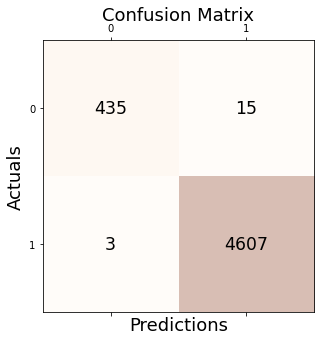

In [16]:
# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_true=validate['trust'], y_pred=predictions)

# Print the confusion matrix using Matplotlib
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')

plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [17]:
# Review the output
output = pd.DataFrame({'domain': validate.domain,
                       'assigned_trust': validate.trust,
                       'prediction': predictions,
                       'correct': validate.trust == predictions})

print(output.loc[output['correct'] == False])
num_false = len(output.loc[output['correct'] == False])
samp_size = len(output)
print('Number of samples: {}'.format(samp_size))
print('Number of errors: {}'.format(num_false))
print('Total correct: {}%'.format(1 - (num_false/samp_size)))

                   domain assigned_trust     prediction  correct
22166     zambianobserver           fake  initial trust    False
25296          altervista  initial trust           fake    False
20732     100percentfedup           fake  initial trust    False
20196    americanprogress           fake  initial trust    False
20224        thehardtimes           fake  initial trust    False
368                    rt           fake  initial trust    False
18372      projectveritas           fake  initial trust    False
16706          freebeacon           fake  initial trust    False
21289   consciouslifenews           fake  initial trust    False
20580  conservativereview           fake  initial trust    False
25293                 msk  initial trust           fake    False
19456              unilad           fake  initial trust    False
20357            alternet           fake  initial trust    False
17900                  me           fake  initial trust    False
25300               plesk

In [18]:
(0.9962450592885376 + 0.9962450592885376)/2

0.9962450592885376

In [19]:
def true_pos(): pass
def true_neg(): pass